# Selection of lakes - EFAS
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 19-11-2024<br>

**Introduction:**<br>

Before I select the lakes to be included in EFAS6, I worked with those already in EFAS5. In GIS, I found the associated polygon in [GLWD](https://www.hydrosheds.org/products/glwd) (either level 1 or 2) and, if possible, the associated in [HydroLakes](https://www.hydrosheds.org/products/hydrolakes). Even though the metadata from EFASv5 lakes is not clear (it mostly references *Burek_lakes* as the source), it seems like the vast majority of lakes were extracted from GLWD, either level 1 or 2. Only a few lakes were taken from GRanD, one from GloFAS reservoirs and another one hast no clear source. The 

This notebook selects lakes to be added in EFASv6. [HydroLakes](https://www.hydrosheds.org/products/hydrolakes) is used as the only dataset source, as it is the most recent and exhaustive. The code does the following:

* Imports lakes and reservoirs already in EFAS.
* Imports the HydroLake dataset and keeps only the lake or controlled lakes within the EFAS domain than comply with these rules:
    * Lake volume of at least 10 hm3.
    * Lake area of at least 5 km².
    * Catchment area of at least 50 km².
    * Degree of regulation of at least 30 days.
* For the resulting selection of lakes, it defines the priority to be added to EFAS (1 for highest priority, 4 for lowest). It sorts the lakes in decreasing order of volume and selects the minimum number of lakes needed to reach a target percentage of the total lake storage in Europe.

| % total volume | priority |
| :------------- | :------- |
| 80             | 1        |
| 85             | 2        |
| 90             | 3        |
| 95             | 4        |
| -              | -9999    |

* Finally, it removes from the selection those lakes already included in EFAS5 either as lakes or reservoirs, and reservoirs selected to be added in EFAS6.

**To do:**

* [x] Find lakes in D2 selection that are not in my selection and viceversa
* [ ] Check why lakes in EFAS are not in HydroLakes
* [x] Remove from selection those lakes already in EFASv5
* [ ] I haven't used at all the GLWD dataset. The reservoirs in EFASv5 were mostly source from GLWD level 1 or 2.

In [3]:
import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
# import dask.dataframe as dd
import geopandas as gpd
import dask_geopandas as dgpd
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from tqdm.notebook import tqdm
from shapely.geometry import Point
from pathlib import Path
from datetime import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from reservoirs_lshm.utils.utils import filter_domain, filter_reservoirs, find_connections, remove_duplicates
from reservoirs_lshm.utils.plots import plot_reservoir_map

In [4]:
# def scientific_format(num):
#     if num == 0:
#         return '0'
#     else:
#         exponent = int(np.log10(abs(num)))
#         prefix = num / 10**(exponent - 1)
#         suffix = '⁰¹²³⁴⁵⁶⁷⁸⁹'[exponent]  # Unicode superscript digits for 0 to 9
#         return f"{prefix:.0f}{suffix}"

## Configuration

In [5]:
# paths
PATH_EFAS5 = Path('Z:/nahaUsers/casadje/EFASv5')
PATH_DATASETS = Path('Z:/nahaUsers/casadje/datasets/')
PATH_HYDROLAKES = PATH_DATASETS / 'lakes' / 'HydroLAKES'
PATH_OUT = PATH_DATASETS / 'lakes' / 'EFASv6' #Path('../results/reservoirs/selection/EFAS/')
PATH_OUT.mkdir(parents=True, exist_ok=True)

# selection limits
MIN_VOLUME = 10 # hm³
MIN_AREA = 5 # km²
MIN_CATCHMENT = 50 # km²
MIN_DOR = 30 # days

## EFAS

### Static map

In [6]:
# load the upstream area map
uparea = rxr.open_rasterio(PATH_EFAS5 / 'static_maps' / 'upArea_European_01min.nc').squeeze(dim='band')
uparea = uparea.where(uparea != -999999, np.nan)

# load the domain
domain = rxr.open_rasterio(PATH_EFAS5 / 'static_maps' / 'domain_area_European_01min.nc').squeeze(dim='band')
lon_min, lat_min, lon_max, lat_max = np.round(domain.rio.bounds(), 6)
efas_cellsize = np.mean(np.diff(domain.x)) # degrees

### Reservoirs

In [7]:
# reservoirs in EFASv5
efas_res = gpd.read_file(PATH_OUT.parent.parent / 'reservoirs' / 'EFASv6' / 'EFAS5' / 'efas5_reservoirs.shp')
efas_res.set_index('ResID', drop=True, inplace=True)
efas_res = efas_res[efas_res.GRAND_ID.notnull()]
efas_res.GRAND_ID = efas_res.GRAND_ID.astype(int)

In [8]:
# reservoirs to be added in EFASv6
grand_to_add = gpd.read_file(PATH_OUT.parent.parent / 'reservoirs' / 'EFASv6' / 'GRanD' / 'grand_to_add.shp')
grand_to_add.set_index('GRAND_ID', drop=True, inplace=True)

### Lakes

#### Raster

In [9]:
efas_raster = xr.open_dataset(PATH_EFAS5 / 'static_maps' / 'lakes_European_01min.nc')['lakes']

# remove rows/columns with all NaN
aux = efas_raster.where(~efas_raster.isnull(), drop=True)
# extract an array of reservoir ID
ids = np.unique(aux)
ids = ids[~np.isnan(ids)]

# extract coordinates of each reservoir
efas_coords = pd.DataFrame(index=ids, columns=['lon', 'lat'])
efas_area = pd.Series(index=ids, dtype=float)
for ID in tqdm(efas_coords.index):
    cell = efas_raster.where(efas_raster == ID, drop=True)
    lon, lat = cell.lon.item(), cell.lat.item()
    efas_coords.loc[int(ID)] = lon, lat
    efas_area.loc[int(ID)] = uparea.sel(x=lon, y=lat, method='nearest', tolerance=1e-4).item()
efas_coords = efas_coords.round(6)

# convert area to km2
efas_area *= 1e-6

del aux

  0%|          | 0/204 [00:00<?, ?it/s]

#### Metadata

no. lakes in the metadata:	203
no. lakes in the raster:	204
lakes missing in the metadata:	[715.0]
lakes missing in the raster:	[]


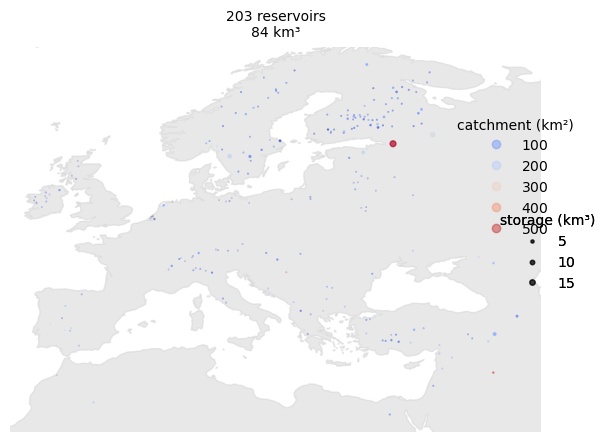

In [15]:
# load EFAS5 metadata
efas = gpd.read_file(PATH_EFAS5 / 'tables' / 'EFAS5_lakes.shp').set_index('LakID', drop=True)
efas[['GLWD_ID', 'Hylak_id']] = efas[['GLWD_ID', 'Hylak_id']].astype('Int64')
efas.drop([col for col in efas.columns if col.startswith('HYLAK')]+ ['A', 'AREA', 'AREA_KM2'], axis=1, errors='ignore', inplace=True)

# # load efas metadata
# efas = pd.read_csv(PATH_EFAS5 / 'tables' / 'EFAS_HRES_lakes_metadata.csv')
# efas.LakID = efas.LakID.astype(int)
# efas.set_index('LakID', inplace=True)
# efas = gpd.GeoDataFrame(efas,
#                         geometry=[Point(xy) for xy in zip(efas.LisfloodX, efas.LisfloodY)],
#                         crs=4326)

# add catchment area (km2)
efas['CATCH_AREA'] = efas_area

# add attributes from the tables used in LISFLOOD
prefix = 'lake'
for file in (PATH_EFAS5 / 'tables').glob(f'{prefix}*.txt'):
    var = file.stem.removeprefix(prefix)
    try:
        df = pd.read_csv(file, sep=' ', header=None)
        df.dropna(axis=1, how='all', inplace=True)
        df.columns = ['LakID', var]
        df.set_index('LakID', inplace=True, drop=True)
        efas[var] = df
    except:
        print(file)
        continue
        
# convert area to km2
efas['area'] /= 1e6

efas.rename(columns={'area': 'AREA_SKM', 'a': 'ALPHA'}, inplace=True)
efas.rename(columns={col: col.upper() for col in efas.columns if col != 'geometry'},
            inplace=True)

print('no. lakes in the metadata:\t{0}'.format(efas.shape[0]))
print('no. lakes in the raster:\t{0}'.format(efas_coords.shape[0]))
print('lakes missing in the metadata:\t{0}'.format(efas_coords.index.difference(efas.index).to_list()))
print('lakes missing in the raster:\t{0}'.format(efas.index.difference(efas_coords.index).to_list()))

# plot lake map
plot_reservoir_map(
    efas.geometry,
    efas.AREA_SKM,
    efas.CATCH_AREA,
    # save=PATH_OUT / 'efasv5_lakes.jpg'
)

The lake 715 was removed manually because it was a duplication of GLWD_ID 1030.

>***Figure 1**. Lakes included in GloFAS. The size of the dots represents the lake area.*

In [16]:
# # map of GloFAS lakes
# fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
# ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
# # glofas.plot(markersize=glofas.A * .5e-2, alpha=.5, ax=ax)#, cmap='coolwarm', c=grand_dams.DOR_PC
# scatter = ax.scatter(glofas.geometry.x, glofas.geometry.y, s=glofas.A / 1000, alpha=.5)
# ax.text(.5, 1.125, 'GloFAS lakes', horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes, fontsize=12)
# text = '{0} lakes\n{1:.0f}·10³ km²'.format(glofas.shape[0], glofas.A.sum() / 1000)
# ax.text(.5, 1.02, text, horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
# ax.axis('off');

# # legend
# legend2 = ax.legend(*scatter.legend_elements(prop='sizes', num=4, alpha=.5), title='area (10³ km²)', bbox_to_anchor=[1.025, .3, .1, .4], frameon=False)
# ax.add_artist(legend2);

# # save
# plt.savefig(f'{path_out}glofas_lakes.jpg', dpi=300, bbox_inches='tight')

# print('no. lakes in GloFAS:\t\t{0}\t({1} with A > {2} km²)'.format(glofas.shape[0], (glofas.A >= MIN_CATCHMENT).sum(), MIN_CATCHMENT))
# print('total lake area in GloFAS:\t{0:.0f} km²'.format(glofas.A.sum()))

In [17]:
# efas.to_file(PATH_OUT / 'efasv5_lakes.shp')

Area of the smallest lake:	1.600 km²


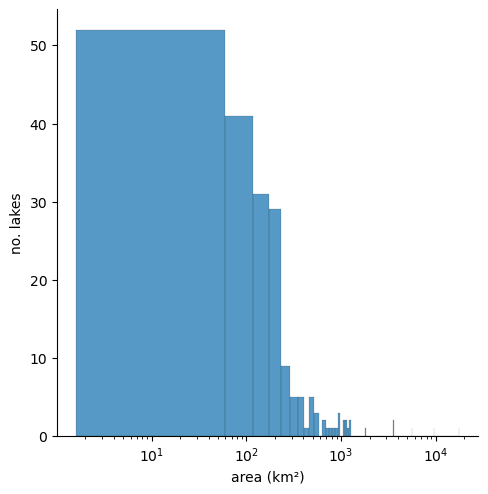

In [18]:
# distribution of the lake area
sns.displot(efas.AREA_SKM)
plt.xlabel('area (km²)')
plt.ylabel('no. lakes');
plt.xscale('log');

print('Area of the smallest lake:\t{0:.3f} km²'.format(efas.AREA_SKM.min()))

>***Figure 2**. Lake surface area distribution in GloFAS.*

As explained in [Zajac et al. (2017)](https://www.sciencedirect.com/science/article/pii/S0022169417301671), only lakes with a minimum area of 50 km² are included in GloFAS.

## HydroLakes

HydroLAKES ([Messager et al., 2016](https://www.nature.com/articles/ncomms13603)) contains more than 1.4 million points of water bodies (both lakes, controlled lakes and reservoirs). 

Interesting fields:

* `Lake_type` indicates the type of water body:
    * 1: lake.
    * 2: reservoir.
    * 3: lake control
* `Lake_area`: surface area in km².
* `Vol_total`: total lake/reservoir volume in hm³.
* `Vol_res`: reported reservoir volume, or storage volume of added lake regulation (hm³)
* `Vol_src`: source of volume data:
    * 1: ‘Vol_total’ is the reported total lake volume from literature
    * 2: ‘Vol_total’ is the reported total reservoir volume from GRanD or literature
    * 3: ‘Vol_total’ is the estimated total lake volume using the geostatistical modeling approach by Messager et al. (2016)
* `Depth_avg`: average depth in m.
* `Dis_avg`: average long-term discharge (m3).
* `Res_time`: average residence time in days.
* `Wshd_area`: area of the lake's watershed in km2.
* `Pour_long` and `Pour_lat` are the coordinates of the pour point in decimal degrees.
* `dis_m3_pyr`: annual average natural discharge.

### Import

#### Outlets

##### All water bodies

In [19]:
# # columns to be used from HydroATLAS
# cols = ['Hylak_id', 'Lake_name', 'Country', 'Continent', 'Poly_src', 'Lake_type', 'Grand_id', 'Lake_area',
#         'Shore_len', 'Shore_dev', 'Vol_total', 'Vol_res', 'Vol_src', 'Depth_avg', 'Dis_avg',
#         'Res_time', 'Elevation', 'Slope_100', 'Wshd_area', 'Pour_long', 'Pour_lat', 'dis_m3_pyr']

# load HydroLAKES
hydrolakes= dgpd.read_file(
    PATH_HYDROLAKES / 'LakeATLAS_v10_shp' / 'LakeATLAS_v10_pnt_east.shp',
    # columns=cols,
    npartitions=10
).set_index('Hylak_id', drop=True)

# keep only lakes (1) and lagoons (3)
# mask_lakes = hydrolakes.Lake_type.isin([1, 3])
# hydrolakes = hydrolakes[mask_lakes].compute()

# filter by extent
mask_extent = (lon_min <= hydrolakes.geometry.x) &  (hydrolakes.geometry.x <= lon_max) & (lat_min <= hydrolakes.geometry.y) & (hydrolakes.geometry.y <= lat_max)
hydrolakes = hydrolakes[mask_extent].compute()

# keep points inside the domain
pbar = tqdm(hydrolakes.iterrows(), total=hydrolakes.shape[0])
mask_domain = [
    ID for ID, point in pbar
    if domain.sel(x=point.geometry.x, y=point.geometry.y, method='nearest').item() == 1
]
hydrolakes = hydrolakes.loc[mask_domain]

# total lake volume in the domain
mask_lakes = hydrolakes.Lake_type.isin([1, 3]) # FOR GLOFAS I ENDED UP USING ONLY VALUE 1
total_lake_volume = hydrolakes[mask_lakes].Vol_total.sum()
print('total lake volume = {0:.0f} km3'.format(total_lake_volume * 1e-3))

  0%|          | 0/107987 [00:00<?, ?it/s]

total lake volume = 4140 km3


In [20]:
hydrolakes.to_file(PATH_OUT / 'hydrolakes_domain.shp')

##### Selection of lakes

In [178]:
hylak_pnt_shp = PATH_OUT / 'hydrolakes_pnt.shp'

In [178]:
if hylak_pnt_shp.is_file():
    # import hydrolake points within the domain
    E1 = gpd.read_file(hylak_pnt_shp).set_index('Hylak_id', drop=True)
    print('{0:>5} lakes ({1:.0f} km3) comply with the catchment, volume and area rules'.format(
        E1.shape[0],
        E1.Vol_total.sum() * 1e-3,
    ))
else:

In [178]:
    mask_catchment = hydrolakes.Wshd_area >= MIN_CATCHMENT
    print('{0:>5} lakes ({1:.0f} km3) have a catchment larger than {2} km2'.format(
        mask_catchment.sum(),
        hydrolakes[mask_lakes & mask_catchment].Vol_total.sum() * 1e-3,
        MIN_CATCHMENT
    ))
    
    mask_volume = hydrolakes.Vol_total >= MIN_VOLUME
    print('{0:>5} lakes ({1:.0f} km3) have a volume larger than {2} hm3'.format(
        mask_volume.sum(),
        hydrolakes[mask_lakes & mask_volume].Vol_total.sum() * 1e-3,
        MIN_VOLUME
    ))

    mask_residence = hydrolakes.Res_time >= MIN_DOR
    print('{0:>5} lakes ({1:.0f} km3) have a residence time larger than {2} days'.format(
        mask_residence.sum(),
        hydrolakes[mask_lakes & mask_residence].Vol_total.sum() * 1e-3,
        MIN_DOR
    ))

    mask_area = hydrolakes.Lake_area >= MIN_AREA
    print('{0:>5} lakes ({1:.0f} km3) have a surface area larger than {2} km2'.format(
        mask_area.sum(),
        hydrolakes[mask_lakes & mask_area].Vol_total.sum() * 1e-3,
        MIN_AREA
    ))

    mask_cvr = mask_lakes & mask_volume & mask_residence & mask_catchment
    print('{0:>5} lakes ({1:.0f} km3) comply with the catchment, volume and residence time rules'.format(
        mask_cvr.sum(),
        hydrolakes[mask_cvr].Vol_total.sum() * 1e-3,
    ))

    mask_cvra = mask_lakes & mask_volume & mask_catchment & mask_area
    print('{0:>5} lakes ({1:.0f} km3) comply with the catchment, volume, and area rules'.format(
        mask_cvra.sum(),
        hydrolakes[mask_cvra].Vol_total.sum() * 1e-3,
    ))
    
    # selection of lakes and accumulated volume
    E1 = hydrolakes[mask_cvra].copy()

    # export selection of points
    E1.to_file(hylak_pnt_shp)

##### D2 selection

In [67]:
# selection of lakes whose polygon overlays the LISFLOOD river network
sel1 = gpd.read_file(PATH_OUT / 'pistoal' / 'EFASselectedLakepoints.shp')
sel1.set_index('Hylak_id', drop=True, inplace=True)

# selection of lakes whose outlet overlays the LISFLOOD river network
sel2 = gpd.read_file(PATH_OUT / 'pistoal' / 'EFASselectedOutlets.shp')
sel2.set_index('HyLak_Id', drop=True, inplace=True)
sel2.index.name = sel1.index.name
sel2.index = sel2.index.astype(int)

# merge the two sets and confirm they are in the EFAS domain
hylak_ids = list(sel1.index.union(sel2.index).intersection(hydrolakes.index))
D2 = hydrolakes.loc[hydrolakes.index.intersection(hylak_ids)]
print(f'{len(hylak_ids)} were selected by Alberto')

del sel1, sel2

mask_catchment = D2.Wshd_area >= MIN_CATCHMENT
print('{0} lakes ({1:.0f} km3) have a catchment larger than {2} km2'.format(
    mask_catchment.sum(),
    D2[mask_catchment].Vol_total.sum() * 1e-3,
    MIN_CATCHMENT
))

mask_volume = D2.Vol_total >= MIN_VOLUME
print('{0} lakes ({1:.0f} km3) have a volume larger than {2} hm3'.format(
    mask_volume.sum(),
    D2[mask_volume].Vol_total.sum() * 1e-3,
    MIN_VOLUME
))

mask_residence = D2.Res_time >= MIN_DOR
print('{0} lakes ({1:.0f} km3) have a residence time larger than {2} days'.format(
    mask_residence.sum(),
    D2[mask_residence].Vol_total.sum() * 1e-3,
    MIN_DOR
))

mask_area = D2.Lake_area >= MIN_AREA
print('{0} lakes ({1:.0f} km3) have a surface area larger than {2} km2'.format(
    mask_area.sum(),
    D2[mask_area].Vol_total.sum() * 1e-3,
    MIN_AREA
))

mask_all = mask_area & mask_volume & mask_residence & mask_catchment
print('{0} lakes ({1:.0f} km3) comply with all the rules above'.format(
    mask_all.sum(),
    D2[mask_all].Vol_total.sum() * 1e-3
))

2190 were selected by Alberto
2189 lakes (3299 km3) have a catchment larger than 50 km2
2190 lakes (3299 km3) have a volume larger than 10 hm3
2190 lakes (3299 km3) have a residence time larger than 30 days
1316 lakes (3274 km3) have a surface area larger than 5 km2
1316 lakes (3274 km3) comply with all the rules above


Below I create two shapefiles to analyse the differences between the E1 and D2 selections.

In [167]:
# export lakes from D2 selection not in E1 selection
ids_diff = D2.index.difference(E1.index)
print(f'{len(ids_diff)} reservoirs in D2 were not selected in E1')
hydrolakes.loc[ids_diff].to_file(PATH_OUT / 'D2_removed.shp')

874 reservoirs in D2 were not selected in E1


In [168]:
# export lakes from E1 selection not in D2 selection
ids_diff = E1.index.difference(D2.index)
print(f'{len(ids_diff)} reservoirs in E1 were not selected in D2')
hydrolakes.loc[ids_diff].to_file(PATH_OUT / 'E1_removed.shp')

1807 reservoirs in E1 were not selected in D2


#### Polygons

In [143]:
hylak_pol_shp = PATH_OUT / 'hydrolakes_pol.shp'
if hylak_pol_shp.is_file():
    
    # import hydrolake polygons within the domain
    hydrolakes_pol = gpd.read_file(hylak_pol_shp).set_index('Hylak_id', drop=True)
    
else:

    # load HydroLakes polygons
    hydrolakes_pol = dgpd.read_file(
        PATH_HYDROLAKES / 'LakeATLAS_v10_shp' / 'LakeATLAS_v10_pol_east.shp',
        # columns=cols,
        npartitions=20
    )
    
    # apply selection of points
    mask = hydrolakes_pol.Hylak_id.isin(hydrolakes.index.tolist())
    hydrolakes_pol = hydrolakes_pol[mask].compute()

    # export selection of polygons
    hydrolakes_pol.to_file(hylak_pol_shp)

MemoryError: Unable to allocate 796. KiB for an array with shape (101897,) and data type uint64

### Connect EFAS with HydroLakes

In the following snippet I search for the `Hylak_id` associated to each lake in EFASv5. After the automatic search, I filled in in GIS the `Hylak_id` for some lakes that the tool could not find. That's why now I load a shapefile, because it includes the manually corrected IDs.

```Python
# find Hylak_id for EFASv5 lakes
map_efas_hylak = find_connections(efas, hydrolakes, max_distance=5 * efas_cellsize)
print('{0} out of {1} EFAS lakes were located in HydroLakes'.format(len(map_efas_hylak), efas.shape[0]))
efas['Hylak_id'] = [map_efas_hylak[ID] if ID in map_efas_hylak else -9999 for ID in efas.index]
print(f'{(efas.Hylak_id == -9999).sum()} lakes in EFAS-5 were not found in HydroLakes')

# export
efas.to_file(PATH_OUT / 'efasv5_lakes.shp')

# MANUAL CORRECTION IN GIS

# import EFAS lakes
efas = gpd.read_file(PATH_OUT / 'efasv5_lakes.shp')
efas.set_index('LakID', drop=True, inplace=True)
print(f'{(efas.Hylak_id == -9999).sum()} lakes in EFAS-5 were not found in HydroLakes')# # import EFAS lakes
efas = gpd.read_file(PATH_OUT / 'efasv5_lakes.shp')
efas.set_index('LakID', drop=True, inplace=True)
print(f'{(efas.Hylak_id == -9999).sum()} lakes in EFAS-5 were not found in HydroLakes')
```

In the end, I did a manual inspection of all the lakes in EFAS5, and assigned them both the ID in GLWD (`GLWD_ID`) and HydroLakes (`HYLAK_ID`).

In [169]:
hylak_ids = set(efas.HYLAK_ID).intersection(hydrolakes.index)

mask_hylak = efas.HYLAK_ID.isin(hylak_ids)

# assign other HydroLake attributes
map_efas_hylak = {efas_id: hylak_id for efas_id, hylak_id in efas[mask_hylak].HYLAK_ID.items() if pd.notnull(hylak_id) and hylak_id in hydrolakes.index}
map_fields = {
    'HYLAK_NAME': 'Lake_name',
    'HYLAK_TYPE': 'Lake_type',
    'HYLAK_AREA': 'Lake_area',
    'HYLAK_VOL': 'Vol_total',
    'HYLAK_DEPT': 'Depth_avg',
    'HYLAK_DIS': 'Dis_avg',
    'HYLAK_DOR': 'Res_time',
    'HYLAK_CAT': 'Wshd_area'
}
for col_dst, col_src in map_fields.items():
    efas.loc[map_efas_hylak.keys(), col_dst] = hydrolakes.loc[map_efas_hylak.values(), col_src].values
    
print('{0} lakes in EFAS5 are reservoirs in HydroLakes'.format((efas.HYLAK_TYPE == 2).sum())) # -1 to remove the value NaN

# # export
# efas.to_file(PATH_OUT / 'efasv5_lakes.shp')

25 lakes in EFAS5 are reservoirs in HydroLakes


## Select lakes 

### Analysis of accumulated volume

In [174]:
# hydrolakes
hydrolakes_acc = hydrolakes[mask_lakes].sort_values('Vol_total', ascending=False).Vol_total.cumsum() / total_lake_volume * 100

# E1 selection
E1.sort_values('Vol_total', ascending=False, inplace=True)
E1_acc = E1.Vol_total.cumsum() / total_lake_volume * 100

# D2 selection
D2_acc = D2.sort_values('Vol_total', ascending=False).Vol_total.cumsum() / total_lake_volume * 100

# EFAS5
efas_acc = efas[efas.HYLAK_TYPE != 2].sort_values('HYLAK_VOL', ascending=False).HYLAK_VOL.cumsum() / total_lake_volume * 100

# intersection of E1 and D2
E1_D2_acc = E1.loc[E1.index.intersection(D2.index)].sort_values('Vol_total', ascending=False).Vol_total.cumsum() / total_lake_volume * 100

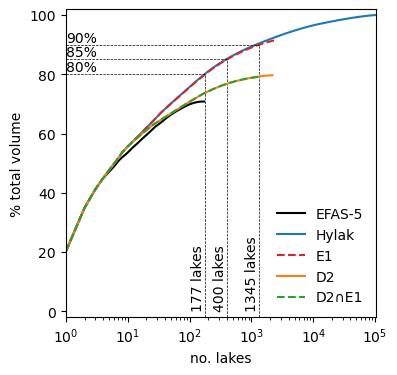

In [175]:
fig, ax = plt.subplots(figsize=(4, 4))

# EFAS5
ax.plot(np.arange(1, len(efas_acc) + 1), efas_acc, c='k', label='EFAS-5')

# HydroLakes
ax.plot(np.arange(1, len(hydrolakes_acc) + 1), hydrolakes_acc, c='C0', label='Hylak')

# E1 selection
ax.plot(np.arange(1, len(E1_acc) + 1), E1_acc, c='C3', ls='--', label='E1')
for target in [80, 85, 90]:
    n = (E1_acc - target).abs().argmin()
    ax.hlines(target, 1, n, color='k', ls='--', lw=.5)
    ax.vlines(n, -2, target, color='k', ls='--', lw=.5)
    ax.text(n, 0, f'{n} lakes', va='bottom', ha='right', rotation=90)
    ax.text(1, target, f'{target}%', va='bottom', ha='left', rotation=0)

# D2 selection
ax.plot(np.arange(1, len(D2_acc) + 1), D2_acc, c='C1', label='D2')

# intersection E1 and D2
n_lakes, pct_vol = len(E1_D2_acc), E1_D2_acc.max()
ax.plot(np.arange(1, n_lakes + 1), E1_D2_acc, c='C2', ls='--', label='D2∩E1')
# ax.hlines(pct_vol, 1, n_lakes, color='k', ls='--', lw=.5)
# ax.vlines(n_lakes, -2, pct_vol, color='k', ls='--', lw=.5)
# ax.text(n_lakes, pct_vol, f'{n_lakes} lakes', va='top', ha='right', rotation=90)
# ax.text(1, pct_vol, f'{E1_D2_acc.max():.0f}%', va='bottom', ha='left', rotation=0)

ax.set(
    xlim=(1, hydrolakes.shape[0]),
    xlabel='no. lakes',
    ylim=(-2, 102),
    ylabel='% total volume'
)
ax.set_xscale('log')
ax.legend(frameon=False, loc=4);

# plt.savefig(PATH_OUT / 'percentage_total_volume.jpg', dpi=300, bbox_inches='tight')

### Lakes to add

I will select lakes to be added in EFASv6 from the `E1` object, i.e., the selection of lakes and controlled lakes in HydroLakes that comply with the lake area, lake volume, catchment area and degree of regulation rules. From those, I will create a classification in terms of `priority`. I will sort the lakes by decreasing volume, and assign priorities depending on the percentage of total lake volume we want to reproduce in EFASv6. For instance, the lakes required to reach a 80% of the total lake volume will have priority 1, those to reach 85% priority 2, ect.

In [176]:
# create dataframe of lakes to be added
to_add_pnt = E1.copy()
to_add_pnt.sort_values('Vol_total', ascending=False, inplace=True)
to_add_acc = to_add_pnt.Vol_total.cumsum() / total_lake_volume * 100

# define priority
to_add_pnt['priority'] = -9999
priorities = {
    4: 95,
    3: 90,
    2: 85,
    1: 80,
}
for priority, target in priorities.items():
    # select lakes to reach the target
    ID = (to_add_acc - target).abs().idxmin()
    # assign priority
    to_add_pnt.loc[:ID, 'priority'] = priority

# remove lakes included in EFASv5
to_add_pnt = to_add_pnt.loc[to_add_pnt.index.difference(efas.HYLAK_ID)]

# remove lakes included as reservoirs in EFASv5
to_add_pnt = to_add_pnt[~to_add_pnt.Grand_id.isin(efas_res.GRAND_ID)]

# remove lakes that will be added to EFASv6 as reservoirs
to_add_pnt = to_add_pnt[~to_add_pnt.Grand_id.isin(grand_to_add.index)]

print(to_add_pnt.priority.value_counts())

4    1266
3     911
2     180
1      73
Name: priority, dtype: int64


In [177]:
# export points
to_add_pnt.to_file(PATH_OUT / 'hydrolakes_pnt_to_add_{0}.shp'.format(datetime.now().strftime('%Y%m%d')))

In [142]:
# apply selection to polygons
if hydrolakes_pol.index.name != 'Hylak_id':
    hydrolakes_pol.set_index('Hylak_id', drop=True, inplace=True)
to_add_pol = hydrolakes_pol.loc[to_add_pnt.index]
to_add_pol['priority'] = -9999
to_add_pol.loc[to_add.index, 'priority'] = to_add_pnt.priority

# export polygons
to_add_pol.to_file(PATH_OUT / 'hydrolakes_pol_to_add_{0}.shp'.format(datetime.now().strftime('%Y%m%d')))

## Conclusion
